# Testing different architectures

## Setting

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

from torchvision import datasets, transforms


torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [3]:
data_path = "../data-unversioned/p1ch7/"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training on device {device}.")

Training on device cuda.


## Utilities

In [7]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, device):
    print(f"Training on device {device}")

    model.to(device=device)
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            # Move the batch tensors to the right device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(
                "{} Epoch {}, Training loss {}".format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)
                )
            )
    
    # Set the model to evaluation mode after training
    model.eval()

In [8]:
def validate(model, train_loader, val_loader, device):
    accdict = {}
    model.to(device=device)

    model.eval()  # Set the model to evaluation mode
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.3f}".format(name, correct / total))
        accdict[name] = correct / total
    return accdict

In [9]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=512, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=512, shuffle=False)
all_acc_dict = collections.OrderedDict()

## Testing models

### Baseline

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [11]:
# We transfer the model (all its parameters) to the device.
model = Net().to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)

all_acc_dict["baseline"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:33:03.753678 Epoch 1, Training loss 0.5445264682173729
2025-04-06 16:33:04.976737 Epoch 10, Training loss 0.2932322844862938
2025-04-06 16:33:06.314172 Epoch 20, Training loss 0.24288026466965676
2025-04-06 16:33:07.662619 Epoch 30, Training loss 0.20191695317626
2025-04-06 16:33:09.009380 Epoch 40, Training loss 0.1604928970336914
2025-04-06 16:33:10.362018 Epoch 50, Training loss 0.12261801399290562
2025-04-06 16:33:11.709902 Epoch 60, Training loss 0.09211544916033745
2025-04-06 16:33:13.055799 Epoch 70, Training loss 0.06474869195371866
2025-04-06 16:33:14.381828 Epoch 80, Training loss 0.04564506560564041
2025-04-06 16:33:15.694446 Epoch 90, Training loss 0.03234805027022958
2025-04-06 16:33:17.022597 Epoch 100, Training loss 0.024964533001184463
2025-04-06 16:33:18.335985 Epoch 110, Training loss 0.024325127620249985
2025-04-06 16:33:19.676022 Epoch 120, Training loss 0.06333071468397974
2025-04-06 16:33:21.009363 Epoch 130, Training loss 0.0

### Augmenting width or channels in convolutions

In [12]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:33:30.659695 Epoch 1, Training loss 0.49784093499183657
2025-04-06 16:33:31.911006 Epoch 10, Training loss 0.25804154574871063
2025-04-06 16:33:33.267023 Epoch 20, Training loss 0.17249756008386613
2025-04-06 16:33:34.642439 Epoch 30, Training loss 0.13751998357474804
2025-04-06 16:33:36.012401 Epoch 40, Training loss 0.09356547687202692
2025-04-06 16:33:37.370506 Epoch 50, Training loss 0.04638153910636902
2025-04-06 16:33:38.763440 Epoch 60, Training loss 0.04661306496709585
2025-04-06 16:33:40.132832 Epoch 70, Training loss 0.017889304272830486
2025-04-06 16:33:41.525252 Epoch 80, Training loss 0.012269156123511493
2025-04-06 16:33:42.895168 Epoch 90, Training loss 0.00944043875206262
2025-04-06 16:33:44.289216 Epoch 100, Training loss 0.008450641995295882
2025-04-06 16:33:45.679402 Epoch 110, Training loss 0.009795048646628857
2025-04-06 16:33:47.046931 Epoch 120, Training loss 0.019458132935687898
2025-04-06 16:33:48.423928 Epoch 130, Training

In [14]:
sum(p.numel() for p in model.parameters())

38386

### $L_2$-regularizarion

In [15]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader, device):
    print(f"Training on device {device}")
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(
                "{} Epoch {}, Training loss {}".format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)
                )
            )

In [16]:
model = Net().to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:33:58.464968 Epoch 1, Training loss 0.5563655212521553
2025-04-06 16:34:00.297464 Epoch 10, Training loss 0.31825807839632037
2025-04-06 16:34:02.345589 Epoch 20, Training loss 0.27435202747583387
2025-04-06 16:34:04.368082 Epoch 30, Training loss 0.24997400119900703
2025-04-06 16:34:06.404768 Epoch 40, Training loss 0.23302816301584245
2025-04-06 16:34:08.437837 Epoch 50, Training loss 0.21289752647280694
2025-04-06 16:34:10.456416 Epoch 60, Training loss 0.1971377693116665
2025-04-06 16:34:12.370602 Epoch 70, Training loss 0.18341801464557647
2025-04-06 16:34:14.062854 Epoch 80, Training loss 0.1759781703352928
2025-04-06 16:34:15.709603 Epoch 90, Training loss 0.15758247077465057
2025-04-06 16:34:17.336278 Epoch 100, Training loss 0.14535901248455046
2025-04-06 16:34:18.944626 Epoch 110, Training loss 0.13738478906452656
2025-04-06 16:34:20.557921 Epoch 120, Training loss 0.13365726955235005
2025-04-06 16:34:22.282023 Epoch 130, Training loss 0.

### Dropout

In [17]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:34:34.817703 Epoch 1, Training loss 0.5393829390406608
2025-04-06 16:34:36.072997 Epoch 10, Training loss 0.3325729489326477
2025-04-06 16:34:37.474699 Epoch 20, Training loss 0.2846547827124596
2025-04-06 16:34:38.892279 Epoch 30, Training loss 0.2452015683054924
2025-04-06 16:34:40.296131 Epoch 40, Training loss 0.21412258595228195
2025-04-06 16:34:41.704258 Epoch 50, Training loss 0.1898181825876236
2025-04-06 16:34:43.117917 Epoch 60, Training loss 0.17504779621958733
2025-04-06 16:34:44.510192 Epoch 70, Training loss 0.15488925017416477
2025-04-06 16:34:45.901939 Epoch 80, Training loss 0.14092841260135175
2025-04-06 16:34:47.317391 Epoch 90, Training loss 0.1346064429730177
2025-04-06 16:34:48.733856 Epoch 100, Training loss 0.1265573874115944
2025-04-06 16:34:50.146391 Epoch 110, Training loss 0.11240634545683861
2025-04-06 16:34:51.600606 Epoch 120, Training loss 0.1065054889768362
2025-04-06 16:34:53.073259 Epoch 130, Training loss 0.10195

### Batch normalization

In [19]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:35:04.265780 Epoch 1, Training loss 0.483073890209198
2025-04-06 16:35:05.578668 Epoch 10, Training loss 0.22298235148191453
2025-04-06 16:35:07.048470 Epoch 20, Training loss 0.12281368337571621
2025-04-06 16:35:08.522075 Epoch 30, Training loss 0.12897639609873296
2025-04-06 16:35:10.005519 Epoch 40, Training loss 0.06385765159502625
2025-04-06 16:35:11.483245 Epoch 50, Training loss 0.02908053258433938
2025-04-06 16:35:12.961069 Epoch 60, Training loss 0.018124451185576616
2025-04-06 16:35:14.447238 Epoch 70, Training loss 0.01628128394950181
2025-04-06 16:35:15.957834 Epoch 80, Training loss 0.013021908421069383
2025-04-06 16:35:17.444008 Epoch 90, Training loss 0.006715220934711397
2025-04-06 16:35:18.901925 Epoch 100, Training loss 0.006692112248856574
2025-04-06 16:35:20.379985 Epoch 110, Training loss 0.005470878520281985
2025-04-06 16:35:21.886267 Epoch 120, Training loss 0.00296445619314909
2025-04-06 16:35:23.385719 Epoch 130, Training l

### Augmenting depth

In [21]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:35:34.230008 Epoch 1, Training loss 0.5992082193493843
2025-04-06 16:35:35.496763 Epoch 10, Training loss 0.29471199214458466
2025-04-06 16:35:36.899722 Epoch 20, Training loss 0.2499143213033676
2025-04-06 16:35:38.300729 Epoch 30, Training loss 0.2158402755856514
2025-04-06 16:35:39.691659 Epoch 40, Training loss 0.18460983857512475
2025-04-06 16:35:41.125625 Epoch 50, Training loss 0.15633469708263875
2025-04-06 16:35:42.527576 Epoch 60, Training loss 0.13366682641208172
2025-04-06 16:35:43.917735 Epoch 70, Training loss 0.12037970535457135
2025-04-06 16:35:45.359031 Epoch 80, Training loss 0.10182641837745905
2025-04-06 16:35:46.761253 Epoch 90, Training loss 0.08202145993709564
2025-04-06 16:35:48.177453 Epoch 100, Training loss 0.07864585909992457
2025-04-06 16:35:49.596086 Epoch 110, Training loss 0.06221487745642662
2025-04-06 16:35:50.991188 Epoch 120, Training loss 0.05575428865849972
2025-04-06 16:35:52.410616 Epoch 130, Training loss 0.

### Residual connections (ResNets) or skip connections

In [23]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:36:02.608255 Epoch 1, Training loss 0.5641944795846939
2025-04-06 16:36:03.839712 Epoch 10, Training loss 0.292143651843071
2025-04-06 16:36:05.254299 Epoch 20, Training loss 0.23761499673128128
2025-04-06 16:36:06.632768 Epoch 30, Training loss 0.19664014801383017
2025-04-06 16:36:08.011952 Epoch 40, Training loss 0.1630691472440958
2025-04-06 16:36:09.403502 Epoch 50, Training loss 0.1334564544260502
2025-04-06 16:36:10.772782 Epoch 60, Training loss 0.10812572203576565
2025-04-06 16:36:12.139397 Epoch 70, Training loss 0.09584462437778711
2025-04-06 16:36:13.510690 Epoch 80, Training loss 0.06986949304118753
2025-04-06 16:36:14.879353 Epoch 90, Training loss 0.05628730850294232
2025-04-06 16:36:16.265181 Epoch 100, Training loss 0.04111219947226345
2025-04-06 16:36:17.649867 Epoch 110, Training loss 0.13892785906791688
2025-04-06 16:36:19.021137 Epoch 120, Training loss 0.04500463102012873
2025-04-06 16:36:20.410492 Epoch 130, Training loss 0.04

In [25]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(
            n_chans, n_chans, kernel_size=3, padding=1, bias=False
        )  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [26]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader, device)

Training on device cuda
2025-04-06 16:37:15.216886 Epoch 1, Training loss 4.4960456669330595
2025-04-06 16:37:41.145983 Epoch 10, Training loss 0.6942802935838699
2025-04-06 16:38:10.495287 Epoch 20, Training loss 0.6931975156068801
2025-04-06 16:38:39.787621 Epoch 30, Training loss 0.6931507050991058
2025-04-06 16:39:08.915041 Epoch 40, Training loss 0.6931499421596528
2025-04-06 16:39:37.941529 Epoch 50, Training loss 0.6931502342224121
2025-04-06 16:40:06.899953 Epoch 60, Training loss 0.6931506365537643
2025-04-06 16:40:35.802763 Epoch 70, Training loss 0.6931509733200073
2025-04-06 16:41:04.673668 Epoch 80, Training loss 0.69315125644207
2025-04-06 16:41:33.561543 Epoch 90, Training loss 0.693151542544365
2025-04-06 16:42:02.405650 Epoch 100, Training loss 0.6931517839431762
2025-04-06 16:42:31.262458 Epoch 110, Training loss 0.6931519687175751
2025-04-06 16:43:00.153149 Epoch 120, Training loss 0.6931522279977799
2025-04-06 16:43:29.081662 Epoch 130, Training loss 0.6931523919105

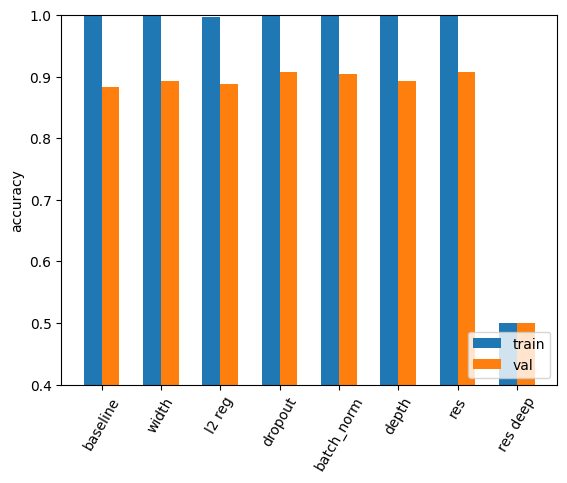

In [34]:
trn_acc = [v["train"] for k, v in all_acc_dict.items()]
val_acc = [v["val"] for k, v in all_acc_dict.items()]

width = 0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label="train")
plt.bar(np.arange(len(val_acc)) + width, val_acc, width=width, label="val")
plt.xticks(np.arange(len(val_acc)) + width / 2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel("accuracy")
plt.legend(loc="lower right")
plt.ylim(0.4, 1)
plt.savefig("accuracy_comparison.png", bbox_inches="tight")
plt.show()